# dataset upload

In [344]:
if (require("rio")== F) install.packages("rio")
library(rio)
url= "https://github.com/agronomy4future/raw_data_practice/raw/main/wheat_grain_size_big_data.RData"
df= import(url)
df1=subset(df, fungicide!="N/A" & Genotype=="Peele")
df1= subset(df1, select = c(-fertilizer, -Shoot, -Length.mm., -Width.mm.))
print(tail(df1,5))

Warning message:
“Missing `trust` will be set to FALSE by default for RData in 2.0.0.”


      Field Genotype Block fungicide planting_date Area.mm2.
96315 South    Peele   III        No         early    13.687
96316 South    Peele   III        No         early    11.058
96317 South    Peele   III        No         early     9.154
96318 South    Peele    II        No          late    18.092
96319 South    Peele    II        No          late    18.092


# to check data structure

In [338]:
xtabs(~ planting_date + fungicide + Genotype, data=df1)

, , Genotype = Peele

             fungicide
planting_date   No  Yes
       early  2054 2243
       late   1628 1636
       normal 2217 2434


# to change variable name

In [346]:
dataA= df1 %>%
              mutate (planting_date= case_when(
                      planting_date== "early"  ~ "Early",
                      planting_date== "normal"  ~ "Normal",
                      planting_date== "late"  ~ "Late",
                      TRUE ~ as.character(planting_date)
  ))

dataA$planting_date=factor(dataA$planting_date, levels=c("Early","Normal","Late"))
print(tail(dataA,5))

      Field Genotype Block fungicide planting_date Area.mm2.
96315 South    Peele   III        No         Early    13.687
96316 South    Peele   III        No         Early    11.058
96317 South    Peele   III        No         Early     9.154
96318 South    Peele    II        No          Late    18.092
96319 South    Peele    II        No          Late    18.092


# data summary

In [285]:
dataB= data.frame(dataA %>%
                    group_by(fungicide, planting_date) %>%
                    dplyr::summarize(across(c(Area.mm2.),
                                            .fns= list(Mean=~mean(., na.rm= TRUE),
                                                       SD= ~sd(., na.rm= TRUE),
                                                       n=~length(.),
                                                       se=~sd(.,na.rm= TRUE) / sqrt(length(.))))))
print(dataB)

`summarise()` has grouped output by 'fungicide'. You can override using the
`.groups` argument.


  fungicide planting_date Area.mm2._Mean Area.mm2._SD Area.mm2._n Area.mm2._se
1        No         Early       13.97312     2.479379        2054   0.05470698
2        No        Normal       15.78524     3.087877        2217   0.06558086
3        No          Late       17.65699     2.787904        1628   0.06909563
4       Yes         Early       14.23392     2.569342        2243   0.05425093
5       Yes        Normal       16.87129     2.610428        2434   0.05291166
6       Yes          Late       17.59145     2.746128        1636   0.06789364


# to create a figure

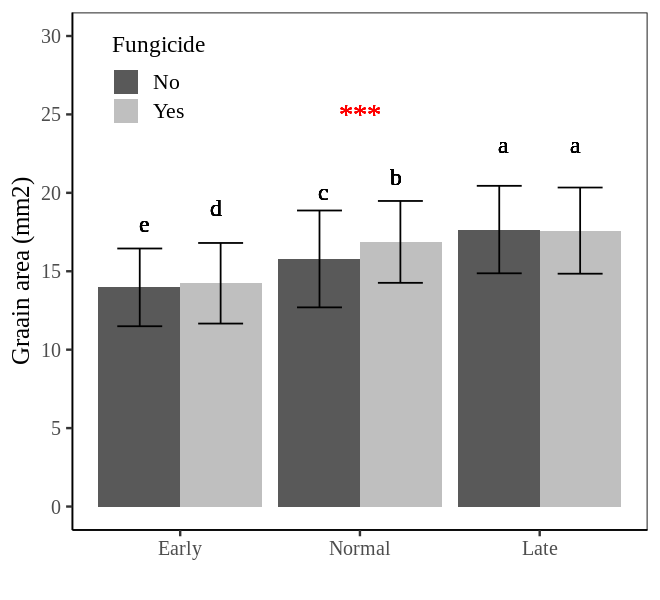

In [347]:
Fig1=ggplot(data=dataB, aes(x=planting_date, y=Area.mm2._Mean, fill=fungicide)) +
  geom_bar(stat="identity", position="dodge", width=0.91, size=1) +
  geom_errorbar(aes(ymin=Area.mm2._Mean-Area.mm2._SD, ymax=Area.mm2._Mean+Area.mm2._SD),
                position=position_dodge(0.9), width=0.5) +
  scale_fill_manual(name="Fungicide", values= c("grey35", "grey75")) +

  geom_text(aes(family="serif", x=0.8, y=18, label="e"), size=5, color="black") +
  geom_text(aes(family="serif", x=1.2, y=19, label="d"), size=5, color="black") +
  geom_text(aes(family="serif", x=1.8, y=20, label="c"), size=5, color="black") +
  geom_text(aes(family="serif", x=2.2, y=21, label="b"), size=5, color="black") +
  geom_text(aes(family="serif", x=2.8, y=23, label="a"), size=5, color="black") +
  geom_text(aes(family="serif", x=3.2, y=23, label="a"), size=5, color="black") +
  geom_text(aes(family="serif", x=2, y=25, label="***"), size=6, color="red") +
  scale_y_continuous(breaks = seq(0, 30, 5), limits = c(0, 30)) +
  labs(x="", y="Graain area (mm2)") +
  theme_classic(base_size= 15, base_family = "serif") +
  theme(legend.position=c(0.15,0.87),
        legend.title= element_text(family="serif", size=14, color="black"),
        legend.key=element_rect(color="white", fill=alpha(0.5)),
        legend.text=element_text(family="serif", face="plain",
                                 size=13, color="black"),
        legend.background= element_rect(fill=alpha(0.5)),
        panel.border= element_rect(color="black", fill=NA, linewidth=0.5),
        axis.line= element_line(linewidth= 0.5, colour= "black"),
        strip.background=element_rect(color="white",
                                      linewidth=0.5, linetype="solid"))

options(repr.plot.width=5.5, repr.plot.height=5)
print(Fig1)

ggsave("Fig1.png", plot= Fig1, width=5.5, height= 5, dpi= 300)

# STAT

In [323]:
model= aov(Area.mm2.~ planting_date + fungicide + planting_date:fungicide + Block, data=df1)
summary(model)

                           Df Sum Sq Mean Sq F value  Pr(>F)    
planting_date               2  24439   12219 1725.27 < 2e-16 ***
fungicide                   1    725     725  102.30 < 2e-16 ***
Block                       1   3915    3915  552.76 < 2e-16 ***
planting_date:fungicide     2    467     234   32.98 5.2e-15 ***
Residuals               12205  86444       7                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [324]:
if(!require(agricolae)) install.packages("agricolae")
library(agricolae)

LSD_Test= LSD.test(model, c("planting_date", "fungicide"))
LSD_Test

$statistics
   MSerror    Df     Mean       CV
  7.082641 12205 15.90348 16.73422

$parameters
        test p.ajusted                  name.t ntr alpha
  Fisher-LSD      none planting_date:fungicide   6  0.05

$means
           Area.mm2.      std    r         se      LCL      UCL   Min    Max
Early:No    13.97312 2.479379 2054 0.05872153 13.85802 14.08822 6.197 22.762
Early:Yes   14.23392 2.569342 2243 0.05619310 14.12378 14.34407 4.816 21.293
Late:No     17.65699 2.787904 1628 0.06595844 17.52770 17.78628 7.525 26.127
Late:Yes    17.59145 2.746128 1636 0.06579698 17.46247 17.72042 6.109 24.533
Normal:No   15.78524 3.087877 2217 0.05652164 15.67444 15.89603 5.772 24.683
Normal:Yes  16.87129 2.610428 2434 0.05394328 16.76555 16.97703 5.746 23.603
                Q25    Q50      Q75
Early:No   12.32625 14.157 15.71500
Early:Yes  12.50550 14.334 16.09150
Late:No    15.84800 17.911 19.50400
Late:Yes   15.81200 17.795 19.47125
Normal:No  13.78500 15.830 17.94600
Normal:Yes 15.21225 17.211 1

### If you use the following R packages, you can easily create graphs that include raw data and calculate responsiveness.

## deltactrl() + descriptivestat()

# loading library for deltactrl() and run

In [296]:
if(!require(remotes)) install.packages("remotes")
if (!requireNamespace("deltactrl", quietly = TRUE)) {
remotes::install_github("agronomy4future/deltactrl", force= TRUE)
}
library(remotes)
library(deltactrl)

In [349]:
dataC= deltactrl(
  data= dataA,
  group_vars= c("planting_date"),
  treatment_var= fungicide,
  control_label= No,
  response_vars= c("Area.mm2.")
)
print(tail(dataC,5))

# A tibble: 5 × 7
  Field Genotype Block fungicide planting_date Area.mm2. responsive_Area.mm2.
  <chr> <chr>    <chr> <chr>     <fct>             <dbl>                <dbl>
1 South Peele    III   No        Early             13.7                    NA
2 South Peele    III   No        Early             11.1                    NA
3 South Peele    III   No        Early              9.15                   NA
4 South Peele    II    No        Late              18.1                    NA
5 South Peele    II    No        Late              18.1                    NA


# loading library for descriptivestat() and run

In [299]:
if(!require(remotes)) install.packages("remotes")
if (!requireNamespace("descriptivestat", quietly = TRUE)) {
  remotes::install_github("agronomy4future/descriptivestat", force= TRUE)
}
library(remotes)
library(descriptivestat)

In [350]:
dataD= descriptivestat(data= dataC, group_vars= c("planting_date","fungicide"),
                     value_vars= c("responsive_Area.mm2."),
                     output_stats= c("sd"))

# to delete control as baseline (in this case, it's 'No fungicide')

In [351]:
dataE= subset(dataD, fungicide!="No")

# to create a figure

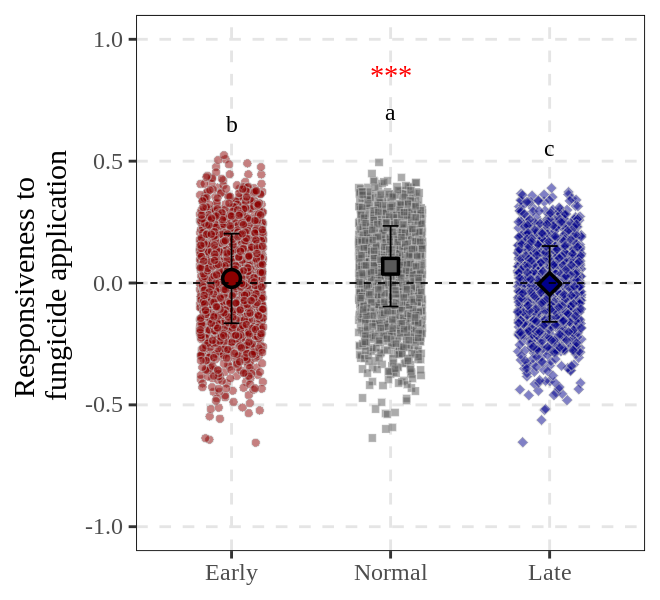

In [352]:
if(!require(ggplot2)) install.packages("ggplot2")
library(ggplot2)

Fig2= ggplot() +

  geom_jitter(data= subset(dataE, category=="observed"),
              aes(x= planting_date, y= responsive_Area.mm2., fill= planting_date, shape=planting_date),
              width=0.2, alpha=0.5,
              size=2, color="grey75") +

  geom_errorbar(data= subset(dataE, category=="mean"),
                aes(x= planting_date, ymin= responsive_Area.mm2.-sd.responsive_Area.mm2.,
                    ymax=responsive_Area.mm2.+sd.responsive_Area.mm2.),
                width= 0.1, color= "black") +

  geom_point(data= subset(dataE, category=="mean"),
             aes(x= planting_date, y= responsive_Area.mm2., fill= planting_date, shape=planting_date),
             size=4, color="black", stroke=1.5) +

  geom_text(aes(family="serif", x=1, y=0.65, label="b"), size=5, color="black") +
  geom_text(aes(family="serif", x=2, y=0.7, label="a"), size=5, color="black") +
  geom_text(aes(family="serif", x=3, y=0.55, label="c"), size=5, color="black") +
  geom_text(aes(family="serif", x=2, y=0.85, label="***"), size=6, color="red") +
  scale_fill_manual(values= c("darkred", "grey35", "darkblue")) +
  scale_shape_manual(values = c(21,22,23)) +
  geom_hline(yintercept=0, linetype="dashed", color="black", size=0.5) +
  scale_y_continuous(breaks=seq(-1,1,0.5), limits = c(-1,1)) +
  #facet_wrap(~ genotype, scales = "free") +
  labs(x= NULL, y="Responsiveness to
  fungicide application") +
  theme_classic(base_size=18, base_family="serif") +
  theme(
    legend.position="none",
    legend.key=element_rect(color="white", fill="white"),
    legend.text=element_text(family="serif", face="plain",
                             size=15, color= "black"),
    legend.background=element_rect(fill=alpha("white", 0.5)),
    strip.background= element_rect(color="white", linewidth=0.5, linetype="solid"),
    panel.border= element_rect(color="black", fill=NA, linewidth=0.5),
    panel.grid.major= element_line(color="grey90", linetype="dashed"),
    axis.line= element_blank()
  )

options(repr.plot.width=5.5, repr.plot.height=5)
print(Fig2)

ggsave("Fig2.png", plot= Fig2, width=5.5, height= 5, dpi= 300)

# STAT

In [309]:
model= aov(responsive_Area.mm2.~ planting_date + Block, data=dataE)
summary(model)

                Df Sum Sq Mean Sq F value Pr(>F)    
planting_date    2   5.78   2.891   102.9 <2e-16 ***
Block            1   4.73   4.728   168.4 <2e-16 ***
Residuals     6309 177.16   0.028                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
3 observations deleted due to missingness

In [310]:
if(!require(agricolae)) install.packages("agricolae")
library(agricolae)

LSD_Test= LSD.test(model, c("planting_date"))
LSD_Test

Loading required package: agricolae

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘agricolae’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘AlgDesign’




$statistics
     MSerror   Df       Mean      CV
  0.02808077 6309 0.03219639 520.472

$parameters
        test p.ajusted        name.t ntr alpha
  Fisher-LSD      none planting_date   3  0.05

$means
       responsive_Area.mm2.       std    r          se         LCL         UCL
Early           0.018664686 0.1838774 2243 0.003538261  0.01172849 0.025600881
Late           -0.003711965 0.1555264 1636 0.004142980 -0.01183361 0.004409685
Normal          0.068801839 0.1653715 2434 0.003396598  0.06214335 0.075460327
              Min       Max         Q25         Q50       Q75
Early  -0.6553383 0.5238543 -0.10503171 0.025826676 0.1516039
Late   -0.6540180 0.3894215 -0.10449054 0.007816263 0.1027503
Normal -0.6359890 0.4952579 -0.03629888 0.090322604 0.1860925

$comparison
NULL

$groups
       responsive_Area.mm2. groups
Normal          0.068801839      a
Early           0.018664686      b
Late           -0.003711965      c

attr(,"class")
[1] "group"